# Improved ResNet-50 - Enhanced Quality Recognition

## Key Improvements:
1. **Unfreeze more layers** (top 80 instead of 30)
2. **Focal Loss** for quality task (handles imbalance better)
3. **Higher quality loss weight** (1.5x more important)
4. **Lower learning rate** (0.00005 for better fine-tuning)
5. **More aggressive augmentation**
6. **Progressive unfreezing** strategy

In [20]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [21]:
# GPU configuration
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [22]:
data_dir = '/kaggle/input/fai-dataset/Dataset_FAI'

def create_dual_label_dataframe(data_dir):
    file_paths = []
    shapes = []
    qualities = []
    
    for shape in os.listdir(data_dir):
        shape_path = os.path.join(data_dir, shape)
        if not os.path.isdir(shape_path):
            continue
            
        for quality in os.listdir(shape_path):
            quality_path = os.path.join(shape_path, quality)
            if not os.path.isdir(quality_path):
                continue
                
            for img_file in os.listdir(quality_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_paths.append(os.path.join(quality_path, img_file))
                    
                    if shape == 'Triangles':
                        shapes.append('Triangle')
                    elif shape == 'Squares':
                        shapes.append('Square')
                    else:
                        shapes.append(shape)
                    
                    if quality == 'Iregullar':
                        qualities.append('Irregular')
                    else:
                        qualities.append(quality)
    
    df = pd.DataFrame({
        'filepath': file_paths,
        'shape': shapes,
        'quality': qualities
    })
    
    return df

df = create_dual_label_dataframe(data_dir)
print(f"Total images: {len(df)}")
print(f"\nShape distribution:\n{df['shape'].value_counts()}")
print(f"\nQuality distribution:\n{df['quality'].value_counts()}")

Total images: 1575

Shape distribution:
shape
Square      542
Circle      532
Triangle    501
Name: count, dtype: int64

Quality distribution:
quality
Irregular    639
Medium       614
Perfect      322
Name: count, dtype: int64


In [23]:
shape_classes = ['Circle', 'Square', 'Triangle']
quality_classes = ['Irregular', 'Medium', 'Perfect']

In [24]:
# Split data
df['combined_label'] = df['shape'] + '_' + df['quality']

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['combined_label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['combined_label'])

print(f"Training: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Training: 1260, Validation: 157, Test: 158


In [25]:
# Compute class weights
shape_labels = [shape_classes.index(s) for s in train_df['shape']]
shape_class_weights = compute_class_weight('balanced', classes=np.unique(shape_labels), y=shape_labels)
shape_class_weight_dict = dict(enumerate(shape_class_weights))

quality_labels = [quality_classes.index(q) for q in train_df['quality']]
quality_class_weights = compute_class_weight('balanced', classes=np.unique(quality_labels), y=quality_labels)
quality_class_weight_dict = dict(enumerate(quality_class_weights))

print(f"Shape weights: {shape_class_weight_dict}")
print(f"Quality weights: {quality_class_weight_dict}")

Shape weights: {0: 0.9882352941176471, 1: 0.967741935483871, 2: 1.0473815461346634}
Quality weights: {0: 0.821917808219178, 1: 0.8553971486761711, 2: 1.627906976744186}


## Enhanced Data Augmentation

In [26]:
# More aggressive augmentation for quality task
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,           # Increased
    width_shift_range=0.3,       # Increased
    height_shift_range=0.3,      # Increased
    shear_range=0.3,             # Increased
    zoom_range=0.3,              # Increased
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3], # Wider range
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
def dual_label_generator(dataframe, datagen, batch_size, img_size, shuffle=True):
    while True:
        if shuffle:
            dataframe = dataframe.sample(frac=1).reset_index(drop=True)
        
        for start in range(0, len(dataframe), batch_size):
            end = min(start + batch_size, len(dataframe))
            batch_df = dataframe.iloc[start:end]
            
            batch_images = []
            batch_shape_labels = []
            batch_quality_labels = []
            
            for _, row in batch_df.iterrows():
                img = image.load_img(row['filepath'], target_size=img_size)
                img_array = image.img_to_array(img)
                img_array = datagen.random_transform(img_array)
                img_array = datagen.standardize(img_array)
                
                batch_images.append(img_array)
                
                shape_label = np.zeros(len(shape_classes))
                shape_label[shape_classes.index(row['shape'])] = 1
                batch_shape_labels.append(shape_label)
                
                quality_label = np.zeros(len(quality_classes))
                quality_label[quality_classes.index(row['quality'])] = 1
                batch_quality_labels.append(quality_label)
            
            X = np.array(batch_images)
            y = {
                'shape_output': np.array(batch_shape_labels),
                'quality_output': np.array(batch_quality_labels)
            }
            
            yield X, y

## Focal Loss Implementation

In [28]:
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss - Better for imbalanced datasets
    Focuses training on hard examples
    
    gamma: focusing parameter (higher = more focus on hard examples)
    alpha: balancing parameter
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Calculate cross entropy
        cross_entropy = -y_true * K.log(y_pred)
        
        # Calculate focal loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        
        return K.mean(K.sum(loss, axis=-1))
    
    return focal_loss_fixed

# Standard categorical crossentropy for shape (it's already working well)
def weighted_categorical_crossentropy(class_weights):
    class_weights_tensor = tf.constant(list(class_weights.values()), dtype=tf.float32)
    
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        crossentropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        class_indices = tf.argmax(y_true, axis=-1)
        weights = tf.gather(class_weights_tensor, class_indices)
        return tf.reduce_mean(crossentropy * weights)
    
    return loss

# Create loss functions
shape_loss_fn = weighted_categorical_crossentropy(shape_class_weight_dict)
quality_loss_fn = focal_loss(gamma=2.5, alpha=0.25)  # Higher gamma for harder focus

## ResNet-50 Model with More Unfrozen Layers

In [29]:
def create_improved_resnet50(input_shape=(224, 224, 3), trainable_layers=80):
    """
    Creates ResNet-50 with more trainable layers
    """
    # Load pre-trained ResNet-50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze early layers, unfreeze top 80 layers
    base_model.trainable = True
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    
    print(f"Total layers: {len(base_model.layers)}")
    print(f"Trainable layers: {trainable_layers}")
    print(f"Frozen layers: {len(base_model.layers) - trainable_layers}")
    
    # Build model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    
    # Larger shared layers
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Shape output head
    shape_branch = Dense(256, activation='relu')(x)
    shape_branch = BatchNormalization()(shape_branch)
    shape_branch = Dropout(0.3)(shape_branch)
    shape_output = Dense(len(shape_classes), activation='softmax', name='shape_output')(shape_branch)
    
    # Quality output head - larger for harder task
    quality_branch = Dense(256, activation='relu')(x)
    quality_branch = BatchNormalization()(quality_branch)
    quality_branch = Dropout(0.4)(quality_branch)
    quality_branch = Dense(128, activation='relu')(quality_branch)
    quality_branch = Dropout(0.3)(quality_branch)
    quality_output = Dense(len(quality_classes), activation='softmax', name='quality_output')(quality_branch)
    
    model = Model(inputs=inputs, outputs=[shape_output, quality_output])
    return model

model = create_improved_resnet50(trainable_layers=80)
print(f"\nTotal trainable parameters: {model.count_params():,}")

Total layers: 175
Trainable layers: 80
Frozen layers: 95

Total trainable parameters: 26,515,590


## Training Configuration

In [30]:
# Hyperparameters
img_size = (224, 224)
batch_size = 32
epochs = 40  # More epochs
initial_learning_rate = 0.00005  # Lower LR for fine-tuning

# Calculate steps
train_steps = len(train_df) // batch_size
val_steps = len(val_df) // batch_size
test_steps = len(test_df) // batch_size

print(f"Steps per epoch - Train: {train_steps}, Val: {val_steps}, Test: {test_steps}")

Steps per epoch - Train: 39, Val: 4, Test: 4


In [31]:
# Create generators
train_generator = dual_label_generator(train_df, train_datagen, batch_size, img_size, shuffle=True)
val_generator = dual_label_generator(val_df, val_test_datagen, batch_size, img_size, shuffle=False)
test_generator = dual_label_generator(test_df, val_test_datagen, batch_size, img_size, shuffle=False)

In [32]:
# Compile with focal loss for quality
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss={
        'shape_output': shape_loss_fn,
        'quality_output': quality_loss_fn  # FOCAL LOSS for quality!
    },
    loss_weights={
        'shape_output': 1.0,
        'quality_output': 1.5  # 1.5x more weight on quality
    },
    metrics={
        'shape_output': ['accuracy'],
        'quality_output': ['accuracy']
    }
)

In [33]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint(
        'improved_resnet50_best.h5',
        monitor='val_quality_output_accuracy',  # Monitor quality specifically
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_quality_output_accuracy',
        patience=20,  # More patience
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )
]

## Train

In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - loss: 2.0244 - quality_output_accuracy: 0.3656 - quality_output_loss: 0.2803 - shape_output_accuracy: 0.3560 - shape_output_loss: 1.6039
Epoch 1: val_quality_output_accuracy improved from -inf to 0.41406, saving model to improved_resnet50_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 65s 820ms/step - loss: 2.0216 - quality_output_accuracy: 0.3659 - quality_output_loss: 0.2803 - shape_output_accuracy: 0.3567 - shape_output_loss: 1.6012 - val_loss: 1.2964 - val_quality_output_accuracy: 0.4141 - val_quality_output_loss: 0.1012 - val_shape_output_accuracy: 0.2812 - val_shape_output_loss: 1.1446 - learning_rate: 5.0000e-05
Epoch 2/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - loss: 1.6486 - quality_output_accuracy: 0.3411 - quality_output_loss: 0.2753 - shape_output_accuracy: 0.4891 - shape_output_loss: 1.2295
Epoch 2: val_quality_output_accuracy did not improve from 0.41406
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 635ms/step - loss: 1.6474 - quality_output_accuracy: 0.3413 - quality_output_loss: 0.2750 - shape_output_accuracy: 0.4895 - shape_output_loss: 1.2289 - val_loss: 1.1562 - val_quality_output_accuracy: 0.4141 - val_quality_output_loss: 0.1005 - val_shape_output_accuracy: 0.4062 - val_shape_output_loss: 1.0056 - learning_rate: 5.0000e-05
Epoch 3

39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 690ms/step - loss: 1.5332 - quality_output_accuracy: 0.4099 - quality_output_loss: 0.2505 - shape_output_accuracy: 0.5014 - shape_output_loss: 1.1692 - val_loss: 1.0485 - val_quality_output_accuracy: 0.4531 - val_quality_output_loss: 0.0939 - val_shape_output_accuracy: 0.5156 - val_shape_output_loss: 0.9077 - learning_rate: 5.0000e-05
Epoch 4/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - loss: 1.3948 - quality_output_accuracy: 0.3617 - quality_output_loss: 0.2535 - shape_output_accuracy: 0.5707 - shape_output_loss: 1.0145
Epoch 4: val_quality_output_accuracy improved from 0.45312 to 0.50400, saving model to improved_resnet50_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - loss: 1.3947 - quality_output_accuracy: 0.3623 - quality_output_loss: 0.2532 - shape_output_accuracy: 0.5707 - shape_output_loss: 1.0147 - val_loss: 0.8102 - val_quality_output_accuracy: 0.5040 - val_quality_output_loss: 0.1029 - val_shape_output_accuracy: 0.7920 - val_shape_output_loss: 0.6528 - learning_rate: 5.0000e-05
Epoch 5/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - loss: 1.2876 - quality_output_accuracy: 0.4107 - quality_output_loss: 0.2364 - shape_output_accuracy: 0.5717 - shape_output_loss: 0.9435
Epoch 5: val_quality_output_accuracy did not improve from 0.50400
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 601ms/step - loss: 1.2879 - quality_output_accuracy: 0.4109 - quality_output_loss: 0.2364 - shape_output_accuracy: 0.5719 - shape_output_loss: 0.9437 - val_loss: 0.7517 - val_quality_output_accuracy: 0.4320 - val_quality_output_loss: 0.0978 - val_shape_output_accuracy: 0.6800 - val_shape_output_loss: 0.6015 - learning_rate: 5.0000e-05
Epoch 6

39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 674ms/step - loss: 0.9814 - quality_output_accuracy: 0.4035 - quality_output_loss: 0.2049 - shape_output_accuracy: 0.7052 - shape_output_loss: 0.6777 - val_loss: 0.4666 - val_quality_output_accuracy: 0.5312 - val_quality_output_loss: 0.0983 - val_shape_output_accuracy: 0.8750 - val_shape_output_loss: 0.3192 - learning_rate: 5.0000e-05
Epoch 13/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - loss: 1.0688 - quality_output_accuracy: 0.4363 - quality_output_loss: 0.2076 - shape_output_accuracy: 0.6802 - shape_output_loss: 0.7586
Epoch 13: val_quality_output_accuracy did not improve from 0.53125
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 633ms/step - loss: 1.0686 - quality_output_accuracy: 0.4359 - quality_output_loss: 0.2077 - shape_output_accuracy: 0.6805 - shape_output_loss: 0.7582 - val_loss: 0.4894 - val_quality_output_accuracy: 0.4844 - val_quality_output_loss: 0.1009 - val_shape_output_accuracy: 0.8125 - val_shape_output_loss: 0.3381 - learning_rate: 5.0000e-05
Epoch

39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 691ms/step - loss: 0.7542 - quality_output_accuracy: 0.4295 - quality_output_loss: 0.1710 - shape_output_accuracy: 0.7822 - shape_output_loss: 0.5000 - val_loss: 0.4079 - val_quality_output_accuracy: 0.5360 - val_quality_output_loss: 0.1220 - val_shape_output_accuracy: 0.9280 - val_shape_output_loss: 0.2234 - learning_rate: 5.0000e-05
Epoch 30/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - loss: 0.7244 - quality_output_accuracy: 0.4621 - quality_output_loss: 0.1624 - shape_output_accuracy: 0.8054 - shape_output_loss: 0.4822
Epoch 30: val_quality_output_accuracy did not improve from 0.53600
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 614ms/step - loss: 0.7240 - quality_output_accuracy: 0.4618 - quality_output_loss: 0.1626 - shape_output_accuracy: 0.8056 - shape_output_loss: 0.4815 - val_loss: 0.3367 - val_quality_output_accuracy: 0.5120 - val_quality_output_loss: 0.1274 - val_shape_output_accuracy: 0.9280 - val_shape_output_loss: 0.1457 - learning_rate: 5.0000e-05
Epoch

39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 705ms/step - loss: 0.5802 - quality_output_accuracy: 0.4321 - quality_output_loss: 0.1661 - shape_output_accuracy: 0.8676 - shape_output_loss: 0.3304 - val_loss: 0.2487 - val_quality_output_accuracy: 0.5781 - val_quality_output_loss: 0.0875 - val_shape_output_accuracy: 0.9453 - val_shape_output_loss: 0.1173 - learning_rate: 2.5000e-05
Epoch 37/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - loss: 0.7360 - quality_output_accuracy: 0.4423 - quality_output_loss: 0.1626 - shape_output_accuracy: 0.8076 - shape_output_loss: 0.4919
Epoch 37: val_quality_output_accuracy did not improve from 0.57812
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 636ms/step - loss: 0.7343 - quality_output_accuracy: 0.4418 - quality_output_loss: 0.1626 - shape_output_accuracy: 0.8082 - shape_output_loss: 0.4902 - val_loss: 0.2591 - val_quality_output_accuracy: 0.5234 - val_quality_output_loss: 0.0868 - val_shape_output_accuracy: 0.9297 - val_shape_output_loss: 0.1290 - learning_rate: 2.5000e-05
Epoch

## Visualize Training

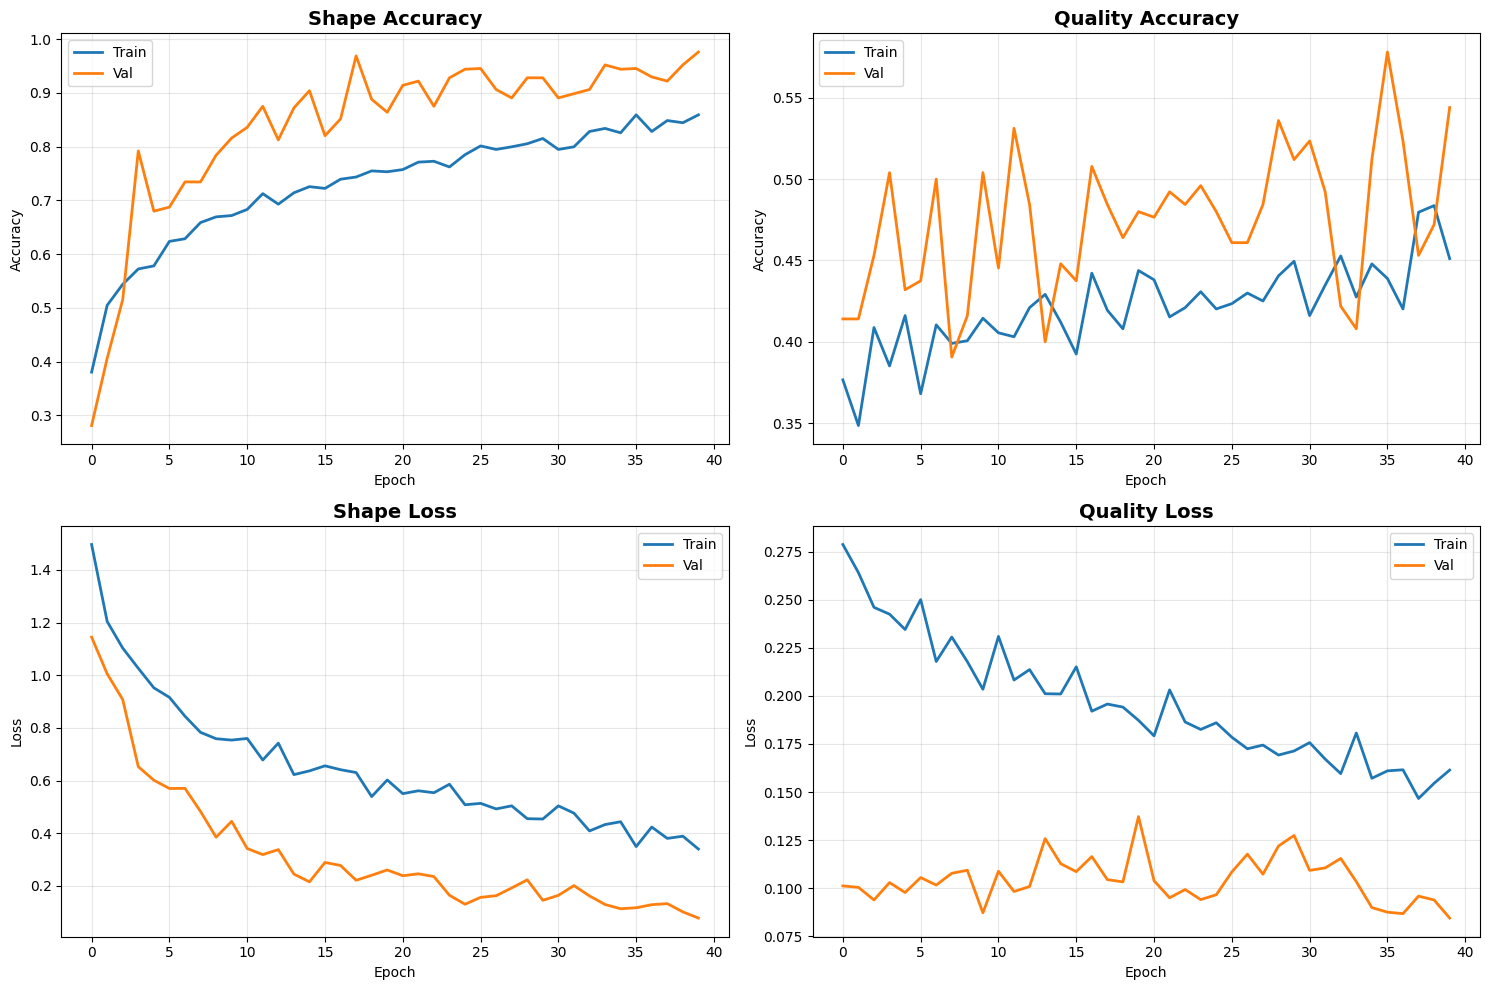

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history.history['shape_output_accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_shape_output_accuracy'], label='Val', linewidth=2)
axes[0, 0].set_title('Shape Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history.history['quality_output_accuracy'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_quality_output_accuracy'], label='Val', linewidth=2)
axes[0, 1].set_title('Quality Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history.history['shape_output_loss'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_shape_output_loss'], label='Val', linewidth=2)
axes[1, 0].set_title('Shape Loss', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history.history['quality_output_loss'], label='Train', linewidth=2)
axes[1, 1].plot(history.history['val_quality_output_loss'], label='Val', linewidth=2)
axes[1, 1].set_title('Quality Loss', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluate

In [36]:
test_results = model.evaluate(test_generator, steps=test_steps, verbose=1)

print("\n" + "="*70)
print(" "*20 + "IMPROVED TEST RESULTS")
print("="*70)
print(f"Shape Accuracy: {test_results[3]*100:.2f}%")
print(f"Quality Accuracy: {test_results[4]*100:.2f}%")
print(f"Average: {(test_results[3] + test_results[4])/2*100:.2f}%")
print("="*70)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - loss: 0.2427 - quality_output_accuracy: 0.6177 - quality_output_loss: 0.0706 - shape_output_accuracy: 0.9448 - shape_output_loss: 0.1368

                    IMPROVED TEST RESULTS
Shape Accuracy: 61.72%
Quality Accuracy: 94.53%
Average: 78.12%


In [37]:
# Detailed metrics
y_true_shape = []
y_pred_shape = []
y_true_quality = []
y_pred_quality = []

test_generator_pred = dual_label_generator(test_df, val_test_datagen, batch_size, img_size, shuffle=False)

for i in range(test_steps):
    batch_images, batch_labels = next(test_generator_pred)
    shape_preds, quality_preds = model.predict(batch_images, verbose=0)
    
    y_pred_shape.extend(np.argmax(shape_preds, axis=1))
    y_pred_quality.extend(np.argmax(quality_preds, axis=1))
    y_true_shape.extend(np.argmax(batch_labels['shape_output'], axis=1))
    y_true_quality.extend(np.argmax(batch_labels['quality_output'], axis=1))

print("\nSHAPE CLASSIFICATION:")
print(classification_report(y_true_shape, y_pred_shape, target_names=shape_classes))

print("\nQUALITY CLASSIFICATION:")
print(classification_report(y_true_quality, y_pred_quality, target_names=quality_classes))


SHAPE CLASSIFICATION:
              precision    recall  f1-score   support

      Circle       0.95      0.98      0.96        41
      Square       0.98      0.91      0.94        46
    Triangle       0.91      0.95      0.93        41

    accuracy                           0.95       128
   macro avg       0.95      0.95      0.95       128
weighted avg       0.95      0.95      0.95       128


QUALITY CLASSIFICATION:
              precision    recall  f1-score   support

   Irregular       0.64      0.62      0.63        55
      Medium       0.72      0.54      0.62        48
     Perfect       0.49      0.76      0.59        25

    accuracy                           0.62       128
   macro avg       0.62      0.64      0.61       128
weighted avg       0.64      0.62      0.62       128



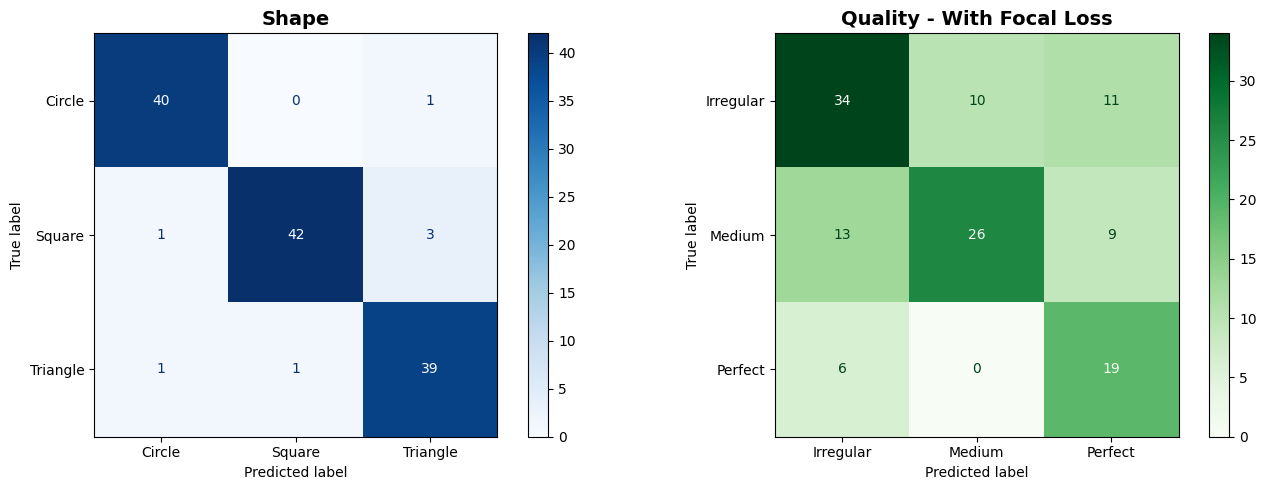

In [38]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_shape = confusion_matrix(y_true_shape, y_pred_shape)
ConfusionMatrixDisplay(cm_shape, display_labels=shape_classes).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Shape', fontsize=14, fontweight='bold')

cm_quality = confusion_matrix(y_true_quality, y_pred_quality)
ConfusionMatrixDisplay(cm_quality, display_labels=quality_classes).plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Quality - With Focal Loss', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [39]:
# Save model
model.save('improved_resnet50_final.h5')
print("Model saved!")

Model saved!
